In [1]:
from vasppy.rdf import RadialDistributionFunction
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.io.vasp import Xdatcar
from pymatgen.core import Structure, Lattice
from pymatgen.io.ase import AseAtomsAdaptor
import pickle
from ase.atoms import Atoms, units 
import numpy as np 
import json, os
from ase.optimize import LBFGS, FIRE, BFGS, MDMin, QuasiNewton
from ase.optimize.precon import PreconLBFGS, PreconFIRE
from mace.calculators import MACECalculator
from ase.filters import FrechetCellFilter

In [2]:
# load in the initial structure 
#job_name ='supercell_gen0_comp10_struct1_vac_site0_start'
job_name = 'supercell_gen4_comp44_struct2_vac_site0_start'
#initial_structure = Structure.from_file(f'../Archived_Vasp_Jobs/Vacancies/{job_name}/POSCAR')
#xdatcar = Xdatcar(f'../Archived_Vasp_Jobs/VCrTiWZr_Summit/Vacancies/Post_VASP/{job_name}/XDATCAR-4') # change to 4 for the 4th gen
initial_structure = Structure.from_file(f'../Archived_Vasp_Jobs/VCrTiWZr_Summit/Fixed-Encut-KPoints/Post_VASP/gen4-vac/{job_name}/POSCAR-1')
xdatcar = Xdatcar(f'../Archived_Vasp_Jobs/VCrTiWZr_Summit/Fixed-Encut-KPoints/Post_VASP/gen4-vac/{job_name}/XDATCAR-9')
final_structure_vasp = xdatcar.structures[-1]

In [3]:

def mace_relaxer(atoms, model_path, fmax = 0.01, steps = 250, relax_cell=True, optimizer = 'LBFGS', device='cpu', default_dtype='float64'):
    if isinstance(atoms, Structure):
        atoms = AseAtomsAdaptor.get_atoms(atoms)
    new_atoms = atoms.copy()
    new_atoms.calc = MACECalculator(model_paths=[model_path], device=device, default_dtype=default_dtype)

    if relax_cell:
        ucf = FrechetCellFilter(new_atoms)
        #obs = TrajectoryObserver(ucf)
        if optimizer == 'LBFGS':
            optimizer = LBFGS(ucf)
        elif optimizer == 'BFGS':
            optimizer = BFGS(ucf)
        elif optimizer == 'MDMin':
            optimizer = MDMin(ucf)
        elif optimizer == 'QuasiNewton':
            optimizer = QuasiNewton(ucf)
        elif optimizer == 'FIRE':
            optimizer = FIRE(ucf)
        elif optimizer == 'PreconFIRE':
            optimizer = PreconFIRE(ucf)
        elif optimizer == 'PreconLBFGS':
            optimizer = PreconLBFGS(ucf)
        #optimizer.attach(obs, interval=loginterval)

    else:
        #constraints = FixAtoms(mask=[False] * len(new_atoms))  # Allow all atoms to move
        # Add constraints to atoms
        #new_atoms.set_constraint(constraints)
        ucf = new_atoms
        if optimizer == 'LBFGS':
            optimizer = LBFGS(ucf)
        elif optimizer == 'BFGS':
            optimizer = BFGS(ucf)
        elif optimizer == 'MDMin':
            optimizer = MDMin(ucf)
        elif optimizer == 'QuasiNewton':
            optimizer = QuasiNewton(ucf)
        elif optimizer == 'FIRE':
            optimizer = FIRE(ucf)
        elif optimizer == 'PreconFIRE':
            optimizer = PreconFIRE(ucf)
        elif optimizer == 'PreconLBFGS':
            optimizer = PreconLBFGS(ucf)

        #obs = TrajectoryObserver(atoms)
        #optimizer.attach(obs, interval=loginterval)

    optimizer.run(fmax=fmax, steps=steps)
    return new_atoms

In [4]:
potential_path = '../Potentials/vcrtiwzr_fep_vac_r6_e1_f25_s100_L2_all_stagetwo_compiled.model'
# now get final structure frim mace 
final_structure_mace = AseAtomsAdaptor.get_structure(mace_relaxer(AseAtomsAdaptor.get_atoms(initial_structure), 
                                    model_path= potential_path,
                                    fmax=0.01, 
                                    steps=1000, 
                                    relax_cell=False, 
                                    optimizer='PreconLBFGS'))

/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


PreconLBFGS:   0  21:40:38    -1179.126030       1.2860
PreconLBFGS:   1  21:40:43    -1179.278175       1.0966
PreconLBFGS:   2  21:40:44    -1179.398534       0.9515
PreconLBFGS:   3  21:40:45    -1179.492321       0.8167
PreconLBFGS:   4  21:40:46    -1179.566332       0.6917
PreconLBFGS:   5  21:40:47    -1179.625147       0.5797
PreconLBFGS:   6  21:40:48    -1179.671836       0.4802
PreconLBFGS:   7  21:40:49    -1179.708667       0.3915
PreconLBFGS:   8  21:40:50    -1179.737407       0.3128
PreconLBFGS:   9  21:40:51    -1179.759503       0.2439
PreconLBFGS:  10  21:40:54    -1179.776206       0.1840
PreconLBFGS:  11  21:40:55    -1179.788613       0.1322
PreconLBFGS:  12  21:40:56    -1179.797658       0.0882
PreconLBFGS:  13  21:40:57    -1179.804134       0.0865
PreconLBFGS:  14  21:40:59    -1179.810170       0.0721
PreconLBFGS:  15  21:41:00    -1179.812492       0.0518
PreconLBFGS:  16  21:41:01    -1179.815525       0.0276
PreconLBFGS:  17  21:41:02    -1179.816733      

ERROR:ase.utils.linesearcharmijo:Passed direction which is not downhill. Aborting...: 1.073989e-03


PreconLBFGS:  24  21:41:07    -1179.821157       0.0493


/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/ase/optimize/precon/lbfgs.py:340: UserWarning: Armijo linesearch failed, resetting Hessian and trying again
  warnings.warn(


PreconLBFGS:  25  21:41:08    -1179.821777       0.0499
PreconLBFGS:  26  21:41:09    -1179.822883       0.0533
PreconLBFGS:  27  21:41:10    -1179.824714       0.0657
PreconLBFGS:  28  21:41:11    -1179.828153       0.1152
PreconLBFGS:  29  21:41:12    -1179.830773       0.1506
PreconLBFGS:  30  21:41:13    -1179.833408       0.1719
PreconLBFGS:  31  21:41:14    -1179.835989       0.1722
PreconLBFGS:  32  21:41:15    -1179.840718       0.1424
PreconLBFGS:  33  21:41:16    -1179.849553       0.1206
PreconLBFGS:  34  21:41:17    -1179.863795       0.0791
PreconLBFGS:  35  21:41:18    -1179.872541       0.0648
PreconLBFGS:  36  21:41:19    -1179.881671       0.0748
PreconLBFGS:  37  21:41:20    -1179.887854       0.0757
PreconLBFGS:  38  21:41:21    -1179.892344       0.0913
PreconLBFGS:  39  21:41:22    -1179.897650       0.1123
PreconLBFGS:  40  21:41:23    -1179.903412       0.1314
PreconLBFGS:  41  21:41:23    -1179.909547       0.1500
PreconLBFGS:  42  21:41:24    -1179.916168      

ERROR:ase.utils.linesearcharmijo:Passed direction which is not downhill. Aborting...: 1.217270e-01


PreconLBFGS:  48  21:41:29    -1179.953697       0.2647
PreconLBFGS:  49  21:41:30    -1179.975899       0.2588
PreconLBFGS:  50  21:41:31    -1180.023113       0.4392
PreconLBFGS:  51  21:41:32    -1180.041548       0.4820
PreconLBFGS:  52  21:41:34    -1180.060793       0.5187
PreconLBFGS:  53  21:41:35    -1180.080331       0.5507
PreconLBFGS:  54  21:41:36    -1180.099698       0.5670
PreconLBFGS:  55  21:41:37    -1180.118544       0.5610
PreconLBFGS:  56  21:41:38    -1180.136825       0.5381
PreconLBFGS:  57  21:41:39    -1180.154732       0.5087
PreconLBFGS:  58  21:41:40    -1180.172304       0.4780
PreconLBFGS:  59  21:41:41    -1180.189364       0.4437
PreconLBFGS:  60  21:41:42    -1180.205780       0.4048
PreconLBFGS:  61  21:41:43    -1180.221567       0.3650
PreconLBFGS:  62  21:41:44    -1180.236776       0.3273
PreconLBFGS:  63  21:41:45    -1180.251602       0.2960
PreconLBFGS:  64  21:41:46    -1180.266351       0.2767
PreconLBFGS:  65  21:41:46    -1180.281093      

In [7]:
print(initial_structure.composition)

Zr29 Ti9 V50 Cr9 W27


In [5]:
vasp_indices_v = [i for i, site in enumerate(final_structure_vasp) if site.species_string == 'V']
vasp_indices_cr = [i for i, site in enumerate(final_structure_vasp) if site.species_string == 'Cr']
vasp_indices_ti = [i for i, site in enumerate(final_structure_vasp) if site.species_string == 'Ti']
vasp_indices_w = [i for i, site in enumerate(final_structure_vasp) if site.species_string == 'W']
vasp_indices_zr = [i for i, site in enumerate(final_structure_vasp) if site.species_string == 'Zr']

mace_indices_v = [i for i, site in enumerate(final_structure_mace) if site.species_string == 'V']
mace_indices_cr = [i for i, site in enumerate(final_structure_mace) if site.species_string == 'Cr']
mace_indices_ti = [i for i, site in enumerate(final_structure_mace) if site.species_string == 'Ti']
mace_indices_w = [i for i, site in enumerate(final_structure_mace) if site.species_string == 'W']
mace_indices_zr = [i for i, site in enumerate(final_structure_mace) if site.species_string == 'Zr']

In [6]:
from vasppy.rdf import RadialDistributionFunction


vasp_rdf_vv = RadialDistributionFunction(structures=[final_structure_vasp],
                                      indices_i=vasp_indices_v)
vasp_rdf_crcr = RadialDistributionFunction(structures=[final_structure_vasp],
                                      indices_i=vasp_indices_cr)
vasp_rdf_titi = RadialDistributionFunction(structures=[final_structure_vasp],
                                        indices_i=vasp_indices_ti)
vasp_rdf_ww = RadialDistributionFunction(structures=[final_structure_vasp],
                                        indices_i=vasp_indices_w)
vasp_rdf_zrzr = RadialDistributionFunction(structures=[final_structure_vasp],
                                        indices_i=vasp_indices_zr)

mace_rdf_vv = RadialDistributionFunction(structures=[final_structure_mace],
                                      indices_i=mace_indices_v)
mace_rdf_crcr = RadialDistributionFunction(structures=[final_structure_mace],
                                      indices_i=mace_indices_cr)
mace_rdf_titi = RadialDistributionFunction(structures=[final_structure_mace],
                                        indices_i=mace_indices_ti)
mace_rdf_ww = RadialDistributionFunction(structures=[final_structure_mace],
                                        indices_i=mace_indices_w)
mace_rdf_zrzr = RadialDistributionFunction(structures=[final_structure_mace],
                                        indices_i=mace_indices_zr)

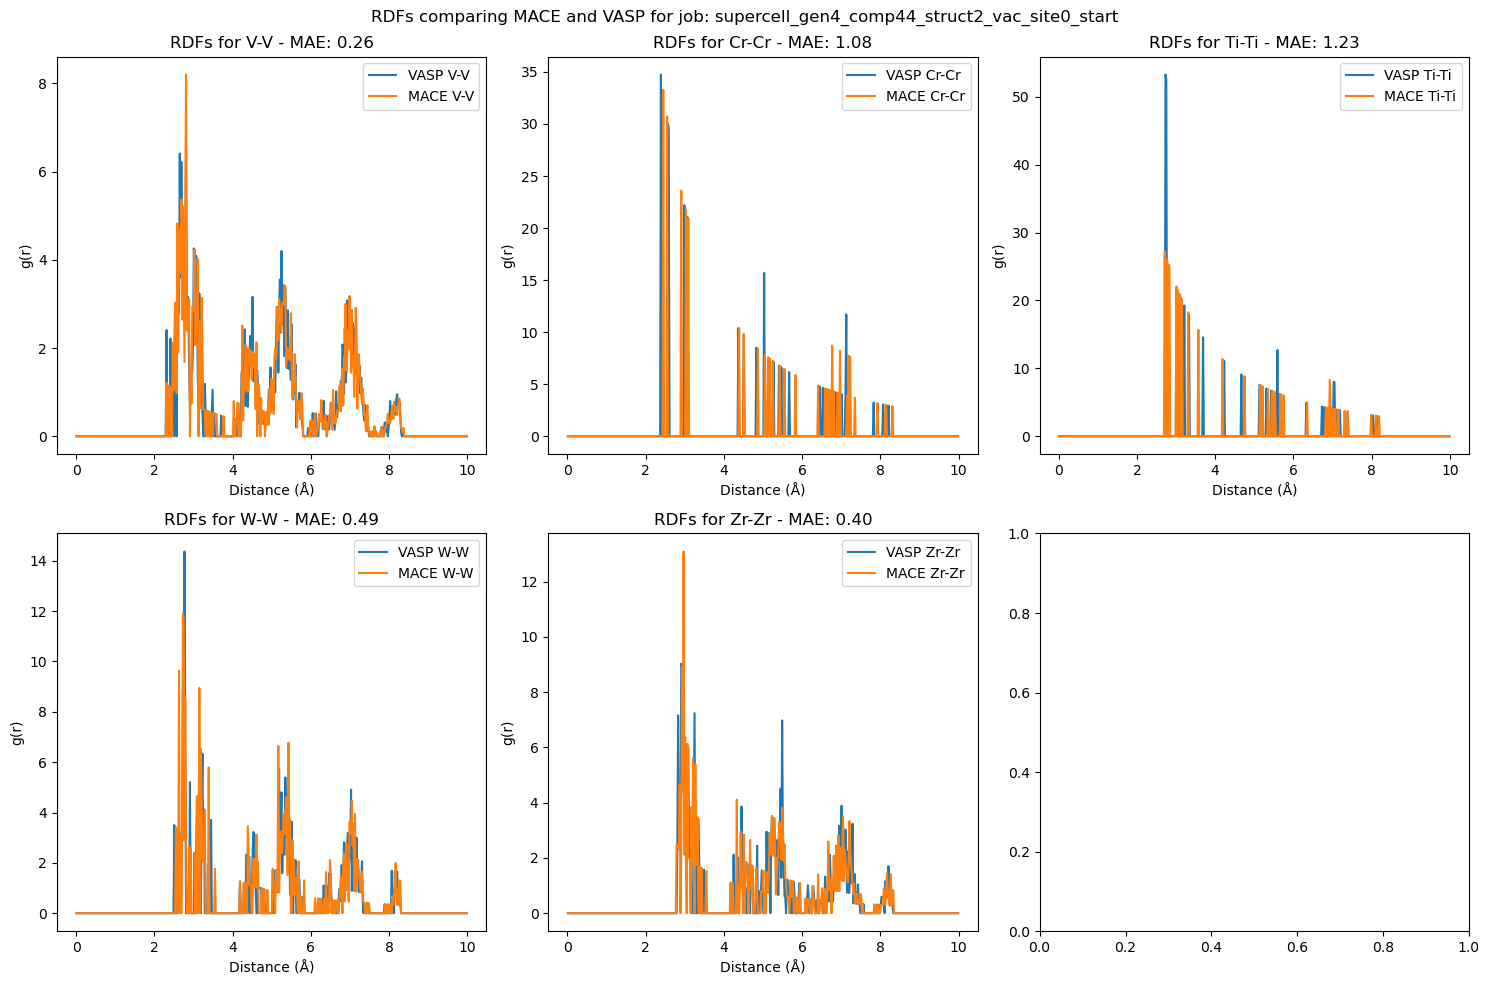

In [7]:
# Create a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
labels = ['V-V', 'Cr-Cr', 'Ti-Ti', 'W-W', 'Zr-Zr']
rdf_pairs = [(vasp_rdf_vv, mace_rdf_vv), (vasp_rdf_crcr, mace_rdf_crcr), (vasp_rdf_titi, mace_rdf_titi), 
             (vasp_rdf_ww, mace_rdf_ww), (vasp_rdf_zrzr, mace_rdf_zrzr)]

# Calculate MAE and plot RDFs for each element pair
for i, (label, (rdf_vasp, rdf_mace)) in enumerate(zip(labels, rdf_pairs)):
    # Determine subplot position
    row = i // 3
    col = i % 3
    
    # Select the subplot
    ax = axs[row, col]
    
    # Calculate Mean Absolute Error
    mae = np.mean(np.abs(rdf_vasp.rdf - rdf_mace.rdf))
    
    # Set the subplot title and labels
    ax.set_title(f"RDFs for {label} - MAE: {mae:.2f}")
    ax.set_xlabel("Distance (Å)")
    ax.set_ylabel("g(r)")
    
    # Plot VASP and MACE RDFs
    ax.plot(rdf_vasp.r, rdf_vasp.rdf, label=f"VASP {label}")
    ax.plot(rdf_mace.r, rdf_mace.rdf, label=f"MACE {label}")
    
    # Add legend to the subplot
    ax.legend()

# Add a common title to all subplots
fig.suptitle(f"RDFs comparing MACE and VASP for job: {job_name}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
from ase.io import read, write
# print the energy over time 
job_path = f'../Archived_Vasp_Jobs/VCrTiWZr_Summit/Fixed-Encut-KPoints/Post_VASP/gen4-vac/{job_name}'

# now get the atoms from each OUTCAR-* file in the job_path 
atoms_list = []

# get all the OUTCAR- files in the job_path
outcar_files = [f for f in os.listdir(job_path) if 'OUTCAR-' in f]

# get the energy from each step of the realaxation for every OUTCAR- file using ase 
for outcar_file in outcar_files:
    # get the atoms from the OUTCAR file 
    atoms = read(f'{job_path}/{outcar_file}', index=':', format='vasp-out')
    # get the energy from the atoms 
    atoms_list.append(atoms)

KeyError: 'Zr_sv/25aed69c'